In [161]:
# --------------------------------------------------------------------
# Importing required libraries
# --------------------------------------------------------------------
import random
import numpy as np
import pandas as pd
import PIL.Image as Image
from glob import glob
from mymodels import (
    ReconNet,
    VisionTransformerTimeSeriesFormalizedWithSAR,
)
from mymodels.unet import Unet
from mymodels.discriminatorv2 import Discriminator
import matplotlib.pyplot as plt
from myutils import imshow
from datetime import datetime

# importing pytorch functions
import torch
from torchvision.utils import make_grid
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as tvtransforms
from torch.nn import SmoothL1Loss, BCELoss

# importing utils required in th code
from utils import subsample
from utils import transforms
from utils.evaluate import ssim, psnr, nmse
from utils.losses import (
    SSIMLoss,
    SSIMLoss_V1,
    MultiScaleLoss,
    spectral_angle_mapper_numpy,
    peak_signal_to_noise_ratio,
    structural_similarity_index,
)
from utils.process import transform_tensor_image, RealisticCloudMaskFunc
from osgeo import gdal
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import mean_squared_error
import math

# Device
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cuda'
# np.random.seed(42)
# random.seed(42)

print("******* STARTED AT ************", datetime.now())

******* STARTED AT ************ 2025-01-16 23:09:35.582816


In [162]:
# To BE DONE

import torch
from tqdm import tqdm
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = "cuda" if torch.cuda.is_available() else "cpu"

if_write = False

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_{current_time}"
path = log_dir
val_path = "/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR_2021"
checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250108-120651_reconstruction"
checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_100.pth"
outputs_folder = f"{checkpoint_base_folder}/{training_model_folder}/masked_outputs"
targets_folder = f"{checkpoint_base_folder}/{training_model_folder}/masked_targets"
inputs_folder = f"{checkpoint_base_folder}/{training_model_folder}/masked_inputs"
cloud_mask_folder = f"{checkpoint_base_folder}/{training_model_folder}/cloud_mask"

In [163]:
class ImagenetDataset(Dataset):
    def __init__(
        self,
        if_SAR=True,
        isval=False,
        add_cloud_mask=True,
        add_kspace_mask=False,
        add_random_time_mask=False,
        val_path="/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/val",
        train_path="/home/snt/projects_lujun/vitCausalSeries/data/intermediate_SAR/output_patches_time_series_with_city/train",
    ):

        self.add_cloud_mask = add_cloud_mask
        self.add_kspace_mask = add_kspace_mask
        self.add_random_time_mask = add_random_time_mask
        self.if_SAR = if_SAR
        self.val_path = val_path
        self.train_path = train_path
        if isval:
            ## combine paths of each imagenet validation image into a single list
            self.files = []
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.val_path):
                self.files.extend(glob(os.path.join(dir, pattern)))
        else:
            ## combine paths of each imagenet training image into a single list
            self.files = []  # get path of each imagenet images
            pattern = "*.tif"
            for dir, _, _ in os.walk(self.train_path):
                self.files.extend(glob(os.path.join(dir, pattern)))

        self.transform = transform_tensor_image
        self.factors = [2, 3, 4, 5, 6, 7, 8, 9, 10]

    def read_tiff(self, file_path):
        dataset = gdal.Open(file_path)
        if not dataset:
            raise FileNotFoundError(f"Unable to open the file: {file_path}")
        band_count = dataset.RasterCount
        bands_data = []
        for i in range(1, band_count + 1):
            band = dataset.GetRasterBand(i)
            band_name = band.GetDescription()
            band_data = band.ReadAsArray()
            bands_data.append(band_data)

        image = np.stack(bands_data, axis=0)
        return image

    def get_mask_func(
        self,
        samp_style,
        factor,
    ):
        center_fractions = 0.08 * 4 / factor
        if samp_style == "random":
            mask_func = subsample.RandomMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        elif samp_style == "equidist":
            mask_func = subsample.EquispacedMaskFunc(
                center_fractions=[center_fractions],
                accelerations=[factor],
            )
        return mask_func

    def add_gaussian_noise(self, x):
        ch, row, col = x.shape
        mean = 0
        var = 0.05
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (ch, row, col))
        gauss = gauss.reshape(ch, row, col)
        noisy = x + gauss
        return noisy.float()

    def __len__(
        self,
    ):
        return len(self.files)

    def __getitem__(self, idx):
        if self.if_SAR:
            channel_count = 13
        else:
            channel_count = 11
        tiff = torch.from_numpy(self.read_tiff(self.files[idx]))
        file_path = self.files[idx]
        file_name = os.path.basename(file_path)
        tiff = self.transform(tiff, target_size=64 * 3, crop_size=60 * 3)
        channels, height, width = tiff.shape
        time_span = int((channels - 1) / channel_count)
        images = np.split(
            tiff, [channel_count * (i + 1) for i in range(time_span)], axis=0
        )
        original_spaces_transformed = []
        masked_spaces = []
        cloud_masks = []
        added_cloud_masks = []

        random_index1 = random.randint(0, len(images) - 2)
        random_index2 = random.randint(0, len(images) - 2)
        random_index = [random_index1, random_index2]
        for i in range(len(images) - 1):
            y = images[i]
            cloud_mask = torch.isnan(y).any(dim=0)
            cloud_mask = (~cloud_mask).int()
            y[:, cloud_mask == 0] = 0
            original_spaces_transformed.append(y.clone())
            masked_kspace = y.clone()

            if random.uniform(0, 1) < 0.5:
                y = torch.rot90(y, 1, [-2, -1])

            if random.uniform(0, 1) < 0.5:
                samp_style = "random"
            else:
                samp_style = "equidist"

            # factor = random.choice(self.factors)
            mask_func = self.get_mask_func(samp_style, factor=2.0)

            if self.add_kspace_mask:  # add kspace mask
                masked_kspace, _ = transforms.apply_mask(masked_kspace, mask_func)
            if self.add_cloud_mask:  # add cloud mask
                masked_kspace, added_cloud_mask = RealisticCloudMaskFunc(
                    masked_kspace, clouds_attributes={"cloud_count": 10}
                )
                added_cloud_masks.append(added_cloud_mask.unsqueeze(0))
            else:
                added_cloud_masks.append(torch.ones_like(cloud_mask.unsqueeze(0)))
            if self.add_random_time_mask:  # add time loss mask
                if i in random_index:
                    masked_kspace = masked_kspace.zero_()

            masked_spaces.append(masked_kspace)
            cloud_masks.append(cloud_mask.unsqueeze(0))

        cls_targets = np.squeeze(images[-1])
        unique_classes = torch.unique(cls_targets[~torch.isnan(cls_targets)])
        num_class = len(unique_classes)

        cls_targets = torch.nan_to_num(cls_targets, nan=num_class)
        cls_targets = cls_targets.long()

        # masked_kspace = self.add_gaussian_noise(y)
        masked_space_concat = torch.cat(masked_spaces, dim=0)
        original_spaces_transformed_concat = torch.cat(
            original_spaces_transformed, dim=0
        )
        cloud_mask_concat = torch.cat(cloud_masks, dim=0)
        added_cloud_masks_concat = torch.cat(added_cloud_masks, dim=0)
        return (
            masked_space_concat,  # inputs
            original_spaces_transformed_concat,  # tragets
            cloud_mask_concat,
            added_cloud_masks_concat,
            cls_targets,
            file_name,
        )


seed = 55

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if_SAR = True
val_dataset = ImagenetDataset(
    if_SAR=if_SAR,
    isval=True,
    add_cloud_mask=True,
    add_kspace_mask=False,
    add_random_time_mask=True,
    val_path=val_path,
)

batch_size = 20
valloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=1,
    pin_memory=True,
    generator=torch.Generator().manual_seed(seed),
)

masked_kspace, _, _, _, _, _ = val_dataset[0]
C, H, W = masked_kspace.shape

channel_count = 13
avrg_img_size = 180  # Don't change this
patch_size = 5  # 10
depth = 6
num_heads = 8
embed_dim = 64  # 64
time_span = C // channel_count
in_chans = C
epoch_max = 100
lr = 1e-4
is_SGD = False
batch_size = 20
seed = 42
if_SAR = True
num_classes = 2

current_time = datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"/home/snt/projects_lujun/vitCausalSeries/data/training/logs/my_experiment_{current_time}_reconstruction"
path = log_dir

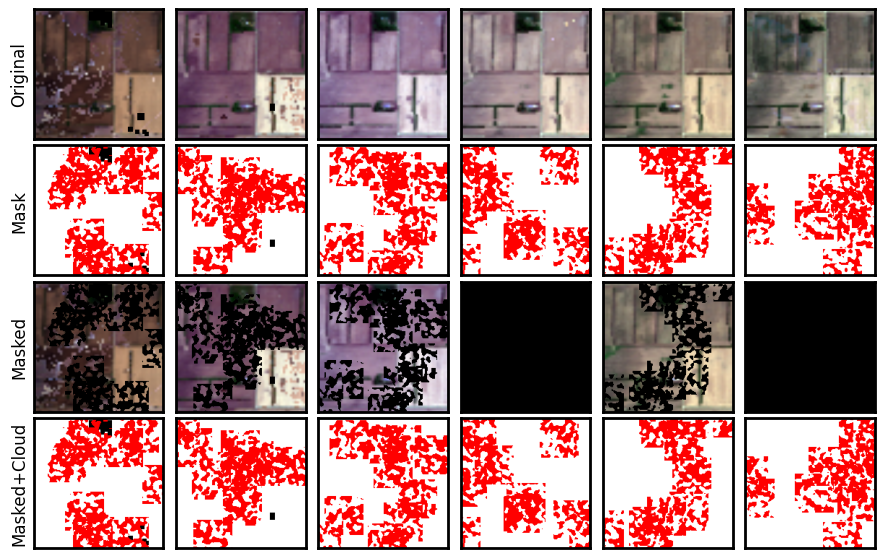

In [164]:
def read_tiff(file_path):
    dataset = gdal.Open(file_path)
    if not dataset:
        raise FileNotFoundError(f"Unable to open the file: {file_path}")
    band_count = dataset.RasterCount
    bands_data = []
    for i in range(1, band_count + 1):
        band = dataset.GetRasterBand(i)
        band_name = band.GetDescription()
        band_data = band.ReadAsArray()
        bands_data.append(band_data)

    image = np.stack(bands_data, axis=0)
    return image


def create_time_series_pseudo_color_image(
    multi_channel_array, cloud_mask, added_cloud_mask
):
    channel_count = 13
    if len(multi_channel_array.shape) != 3:
        raise ValueError("Input Array Shold be H W C")
    channel_list = [3, 2, 1]
    channels, h, w = multi_channel_array.shape
    time_span = int((channels - 1) / channel_count)
    images = np.split(
        multi_channel_array, [channel_count * (i + 1) for i in range(time_span)], axis=0
    )
    cloud_masks = np.split(cloud_mask, [i + 1 for i in range(time_span)], axis=0)
    added_cloud_masks = np.split(
        added_cloud_mask, [i + 1 for i in range(time_span)], axis=0
    )
    time_series_images = []
    background_cloud_images = []
    for i, image in enumerate(images):
        image = np.transpose(image, (1, 2, 0))
        pseudo_color_image = image[:, :, channel_list]
        time_series_images.append(pseudo_color_image)

        # nan_mask = np.isnan(pseudo_color_image).any(axis=-1)  # 掩码，标记 NaN 的位置

        background_cloud_image = np.full((h, w, 3), 0, dtype=np.uint8)  # ALL black
        background_cloud_image[cloud_masks[i].squeeze(0) == 1] = [
            255,
            255,
            255,
        ]  # Eecept mask white

        background_cloud_image[added_cloud_masks[i].squeeze(0) == 0] = [
            255,
            0,
            0,
        ]
        background_cloud_images.append(background_cloud_image)

    return time_series_images, background_cloud_images


def save_tiff(image, file_path):
    """
    Save a multi-channel image as a TIFF file.
    """
    if len(image.shape) == 3:
        channels, height, width = image.shape
    else:
        raise ValueError("Image must have 3 dimensions (C, H, W)")

    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(file_path, width, height, channels, gdal.GDT_Float32)

    for i in range(channels):
        dataset.GetRasterBand(i + 1).WriteArray(image[i])

    dataset.FlushCache()
    dataset = None  # Close the file


def test_image_transformation(dataset, idx):

    (
        masked_kspace,
        original_image,
        cloud_mask,
        added_cloud_masks_concat,
        cls_target,
        _,
    ) = dataset[idx]

    save_tiff(np.array(masked_kspace), "data/visualization/masked_kspace.tiff")
    save_tiff(np.array(original_image), "data/visualization/original_image.tiff")
    save_tiff(np.array(cloud_mask), "data/visualization/cloud_mask.tiff")
    save_tiff(
        np.array(added_cloud_masks_concat),
        "data/visualization/added_cloud_masks_concat.tiff",
    )

    time_series_images_original, background_cloud_images_original = (
        create_time_series_pseudo_color_image(
            original_image, cloud_mask, added_cloud_masks_concat
        )
    )
    time_series_images_masked, background_cloud_images_masked = (
        create_time_series_pseudo_color_image(
            masked_kspace, cloud_mask, added_cloud_masks_concat
        )
    )
    all_images = [
        time_series_images_original,
        background_cloud_images_original,
        time_series_images_masked,
        background_cloud_images_masked,
    ]

    fig, axes = plt.subplots(
        len(all_images),
        len(time_series_images_masked),
        figsize=(11, 7),
        gridspec_kw={"hspace": 0.05, "wspace": 0.01},
    )

    # Set up the style for all subplots
    for ax in axes.flatten():
        ax.spines["top"].set_color("black")
        ax.spines["bottom"].set_color("black")
        ax.spines["left"].set_color("black")
        ax.spines["right"].set_color("black")
        ax.spines["top"].set_linewidth(2)
        ax.spines["bottom"].set_linewidth(2)
        ax.spines["left"].set_linewidth(2)
        ax.spines["right"].set_linewidth(2)
        ax.set_xticks([])
        ax.set_yticks([])

    # Plot images for each row
    dict_name = {
        0: "Original",
        1: "Mask",
        2: "Masked",
        3: "Masked+Cloud",
    }

    for i, image_list in enumerate(all_images):
        for j in range(len(image_list)):
            axes[i, j].imshow(image_list[j], cmap="gray")
            axes[i, j].axis("on")
            if j == 0:  # Add a title only to the first column
                axes[i, j].set_ylabel(dict_name[i], fontsize=12, color="black")

    plt.show()


idx = 123  # 150/ 40 / 521 / 123
test_image_transformation(val_dataset, idx)

In [165]:
masked_kspace_loaded = read_tiff("data/visualization/masked_kspace.tiff")
original_image_loaded = read_tiff("data/visualization/original_image.tiff")
cloud_mask_loaded = read_tiff("data/visualization/cloud_mask.tiff")
added_cloud_masks_concat_loaded = read_tiff(
    "data/visualization/added_cloud_masks_concat.tiff"
)

In [166]:
from mymodels import VisionTransformer, ReconNet

masked_kspace, _, _, _, _, _ = val_dataset[0]
C, H, W = masked_kspace.shape

channel_count = 11
avrg_img_size = 180  # Don't change this
patch_size = 5  # 10
depth = 6
num_heads = 8
embed_dim = 11  # 64
time_span = C // channel_count
in_chans = 11
epoch_max = 100
lr = 1e-4
is_SGD = False
batch_size = 60
seed = 42

## Model S-VIT
net = VisionTransformer(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
)

model = ReconNet(net).to(device)
checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250109-121958_reconstruction_single_vit"
checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_60.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])


inputs, targets, cloud_mask = (
    torch.from_numpy(masked_kspace_loaded),
    torch.from_numpy(original_image_loaded),
    torch.from_numpy(cloud_mask_loaded),
)

split_inputs = torch.split(
    inputs.unsqueeze(0), 13, dim=1
)  # 切分为 6 个 [48, 11, 180, 180]
output_list = []

for split_input in split_inputs:
    split_input = split_input[:, 0:11, :, :].to(device)
    output = model(split_input)
    output_list.append(output.cpu())

outputs_single_vit = torch.cat(output_list, dim=1).to(device)

/tmp/ipykernel_1028417/216883889.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [167]:
channel_count = 11
avrg_img_size = 180  # Don't change this
patch_size = 5  # 10
depth = 6
num_heads = 8
embed_dim = 64  # 64
time_span = C // channel_count
in_chans = 66
epoch_max = 100
lr = 1e-4
is_SGD = False
batch_size = 20
seed = 42
if_SAR = False
num_classes = 2

net = VisionTransformerTimeSeriesFormalizedWithSAR(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    is_CSA=False,
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
    use_time_embed=False,
)


model_MTS_VIT = ReconNet(net).to(device)

checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250108-121717_reconstruction"
checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_100.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
model_MTS_VIT.load_state_dict(checkpoint["model_state_dict"])

split_inputs = torch.split(inputs.unsqueeze(0), 13, dim=1)
input_list = []
for split_input in split_inputs:
    split_input = split_input[:, 0:11, :, :].to(device)
    input_list.append(split_input.cpu())

inputs_single_MTS_VIT = torch.cat(input_list, dim=1).to(device)

outputs_MTS_VIT = model_MTS_VIT(inputs_single_MTS_VIT.to(device))

/tmp/ipykernel_1028417/750275688.py:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [168]:
channel_count = 11
avrg_img_size = 180  # Don't change this
patch_size = 5  # 10
depth = 6
num_heads = 8
embed_dim = 64  # 64
time_span = C // channel_count
in_chans = 78
epoch_max = 100
lr = 1e-4
is_SGD = False
batch_size = 20
seed = 42
if_SAR = False
num_classes = 2
checkpoint_base_folder = "/home/snt/projects_lujun/vitCausalSeries/data/training/logs"
training_model_folder = "my_experiment_20250108-120651_reconstruction"
checkpoint_path = f"{checkpoint_base_folder}/{training_model_folder}/checkpoint_100.pth"

net = VisionTransformerTimeSeriesFormalizedWithSAR(
    avrg_img_size=avrg_img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    is_LSA=False,  # ---------------Parameter for adding LSA component
    is_SPT=False,  # ---------------Parameter for adding SPT component
    is_CSA=False,
    rotary_position_emb=False,  # ---------------Parameter for adding ROPE component
    use_pos_embed=True,
    use_time_embed=False,
)

model_SMTS_VIT = ReconNet(net).to(device)
checkpoint = torch.load(checkpoint_path, map_location=device)
model_SMTS_VIT.load_state_dict(checkpoint["model_state_dict"])


outputs = model_SMTS_VIT(inputs.unsqueeze(0).to(device))

split_outputs = torch.split(outputs, 13, dim=1)
outputs_list = []
for split_output in split_outputs:
    split_output = split_output[:, 0:11, :, :].to(device)
    outputs_list.append(split_output.cpu())

output_single_SMTS_VIT = torch.cat(outputs_list, dim=1).to(device)

/tmp/ipykernel_1028417/3656705671.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


In [169]:
def create_time_series_pseudo_color_image(
    multi_channel_array, cloud_mask, added_cloud_mask, channel_count=13
):

    if len(multi_channel_array.shape) != 3:
        raise ValueError("Input Array Shold be H W C")

    multi_channel_array = multi_channel_array.cpu().numpy()
    cloud_mask = cloud_mask.cpu().numpy()
    added_cloud_mask = added_cloud_mask.cpu().numpy()

    channel_list = [3, 2, 1]
    channels, h, w = multi_channel_array.shape
    time_span = int((channels - 1) / channel_count)
    images = np.split(
        multi_channel_array, [channel_count * (i + 1) for i in range(time_span)], axis=0
    )
    cloud_masks = np.split(cloud_mask, [i + 1 for i in range(time_span)], axis=0)
    added_cloud_masks = np.split(
        added_cloud_mask, [i + 1 for i in range(time_span)], axis=0
    )
    time_series_images = []
    background_cloud_images = []
    for i, image in enumerate(images):
        image = np.transpose(image, (1, 2, 0))
        pseudo_color_image = image[:, :, channel_list]
        time_series_images.append(pseudo_color_image)

        background_cloud_image = np.full((h, w, 3), 0, dtype=np.uint8)  # ALL black
        background_cloud_image[cloud_masks[i].squeeze(0) == 1] = [
            255,
            255,
            255,
        ]  # Eecept mask white

        background_cloud_image[added_cloud_masks[i].squeeze(0) == 0] = [
            255,
            0,
            0,
        ]
        background_cloud_images.append(background_cloud_image)

    return time_series_images, background_cloud_images

In [170]:
masked_kspace_loaded = read_tiff("data/visualization/masked_kspace.tiff")
original_image_loaded = read_tiff("data/visualization/original_image.tiff")
cloud_mask_loaded = read_tiff("data/visualization/cloud_mask.tiff")
added_cloud_masks_concat_loaded = read_tiff(
    "data/visualization/added_cloud_masks_concat.tiff"
)

inputs, targets, cloud_mask, added_cloud_mask = (
    torch.from_numpy(masked_kspace_loaded).unsqueeze(0),
    torch.from_numpy(original_image_loaded).unsqueeze(0),
    torch.from_numpy(cloud_mask_loaded).unsqueeze(0),
    torch.from_numpy(added_cloud_masks_concat_loaded).unsqueeze(0),
)

target_images, _ = create_time_series_pseudo_color_image(
    targets[0, :, :, :],
    cloud_mask[0, :, :, :],
    added_cloud_mask[0, :, :, :],
    channel_count=13,
)


input_images, _ = create_time_series_pseudo_color_image(
    inputs[0, :, :, :],
    cloud_mask[0, :, :, :],
    added_cloud_mask[0, :, :, :],
    channel_count=13,
)

output_images_single_vit, _ = create_time_series_pseudo_color_image(
    outputs_single_vit[0, :, :, :].detach(),
    cloud_mask[0, :, :, :],
    added_cloud_mask[0, :, :, :],
    channel_count=11,
)

output_images_MTS_VIT, _ = create_time_series_pseudo_color_image(
    outputs_MTS_VIT[0, :, :, :].detach(),
    cloud_mask[0, :, :, :],
    added_cloud_mask[0, :, :, :],
    channel_count=11,
)


output_images_SMTS_VI, _ = create_time_series_pseudo_color_image(
    output_single_SMTS_VIT[0, :, :, :].detach(),
    cloud_mask[0, :, :, :],
    added_cloud_mask[0, :, :, :],
    channel_count=11,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.020011289..0.75473744].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0057340665..0.9630221].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.050335336..0.98574877].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029133864..0.044823777].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.056845773..1.0290469].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.029133864..0.044823777].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). G

Text(0, 0.5, 'SMTS-ViT')

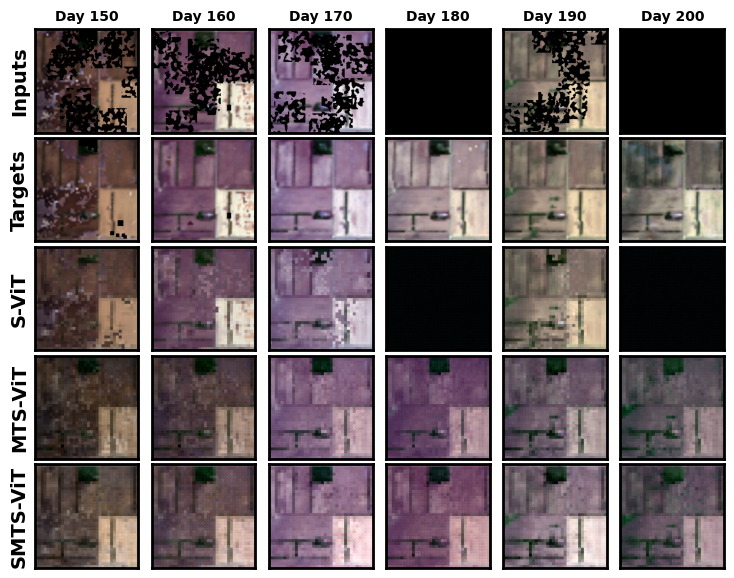

In [171]:
fig, axes = plt.subplots(
    5,
    len(output_images_SMTS_VI),
    figsize=(9, 7),
    gridspec_kw={"hspace": 0.05, "wspace": 0.05},
)
for ax in axes.flatten():
    ax.spines["top"].set_color("black")
    ax.spines["bottom"].set_color("black")
    ax.spines["left"].set_color("black")
    ax.spines["right"].set_color("black")
    ax.spines["top"].set_linewidth(2)
    ax.spines["bottom"].set_linewidth(2)
    ax.spines["left"].set_linewidth(2)
    ax.spines["right"].set_linewidth(2)
    ax.set_xticks([])
    ax.set_yticks([])

time_labels = ["Day 150", "Day 160", "Day 170", "Day 180", "Day 190", "Day 200"]

for j in range(len(input_images)):
    axes[0, j].imshow(input_images[j], cmap="gray")
    axes[0, j].axis("on")
    axes[0, j].set_title(time_labels[j], fontsize=10, fontweight="bold", color="black")
for j in range(len(input_images)):
    axes[1, j].imshow(target_images[j], cmap="gray")
    axes[1, j].axis("on")
    axes[0, j].set_title(time_labels[j], fontsize=10, fontweight="bold", color="black")
for j in range(len(output_images_single_vit)):
    axes[2, j].imshow(output_images_single_vit[j], cmap="gray")
    axes[2, j].axis("on")
    axes[0, j].set_title(time_labels[j], fontsize=10, fontweight="bold", color="black")
for j in range(len(output_images_MTS_VIT)):
    axes[3, j].imshow(output_images_MTS_VIT[j], cmap="gray")
    axes[3, j].axis("on")
    axes[0, j].set_title(time_labels[j], fontsize=10, fontweight="bold", color="black")
for j in range(len(output_images_SMTS_VI)):
    axes[4, j].imshow(output_images_SMTS_VI[j], cmap="gray")
    axes[4, j].axis("on")
    axes[0, j].set_title(time_labels[j], fontsize=10, fontweight="bold", color="black")
axes[0, 0].set_ylabel("Inputs", fontsize=14, fontweight="bold", color="black")
axes[1, 0].set_ylabel("Targets", fontsize=14, fontweight="bold", color="black")
axes[2, 0].set_ylabel("S-ViT", fontsize=14, fontweight="bold", color="black")
axes[3, 0].set_ylabel("MTS-ViT", fontsize=14, fontweight="bold", color="black")
axes[4, 0].set_ylabel("SMTS-ViT", fontsize=14, fontweight="bold", color="black")

In [120]:
cloud_mask.shape

torch.Size([1, 6, 180, 180])

In [121]:
outputs_single_vit.shape

torch.Size([1, 66, 180, 180])